# Creation of Phantoms

## 📝 Introduction


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import napari
from tqdm import tqdm
from nDTomo.sim.shapes2D import create_circle, create_rectangle, create_triangle, create_equilateral_triangle, create_ellipse, create_star, create_voronoi

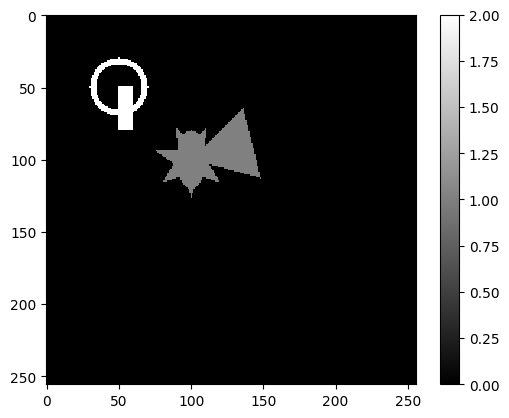

In [2]:
im = np.zeros((256, 256), dtype='float32')
imn = create_circle(im, center=(50,50), radius=20, fill_value=2, thickness=4)
imn = create_rectangle(im, corner=(50,50), width=10, height=30, fill_value=2)
imn = create_equilateral_triangle(im, p1=(100,100), side=50, fill_value=1, orientation='random')
imn = create_ellipse(im, center=(100,100), axes_radii=(20, 10), fill_value=1)
imn = create_star(im, center=(100,100), n_points=7, r_outer=26, r_inner=12, 
                  fill_value=1, angle_offset=0.0)


plt.figure(1);plt.clf()
plt.imshow(imn, cmap='gray', interpolation='None')
plt.colorbar()
plt.show()

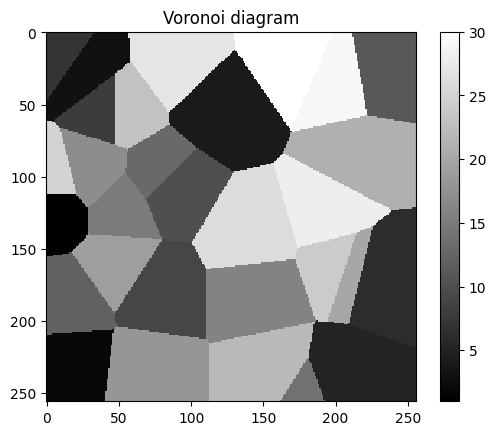

In [3]:
# Define random seed points
size = (256, 256)
num_points = 30
seed_points = [(np.random.randint(0, size[0]), np.random.randint(0, size[1])) for _ in range(num_points)]

# Generate Voronoi diagram
img = np.zeros(size, dtype=int)
imn = create_voronoi(img, seed_points)

plt.figure(1);plt.clf()
plt.imshow(imn, cmap='gray', interpolation='None')
plt.colorbar()
plt.title('Voronoi diagram')
plt.show()

In [4]:

from nDTomo.sim.shapes3D import (create_sphere, create_cube, create_cuboid, create_cylinder, create_cone, create_pyramid, 
                                 create_torus, create_ellipsoid, create_hexagonal_prism,
                                 create_mobius_strip, create_menger_sponge)

In [5]:

# Create a 3D array of zeros
shape = (256, 256, 256)  # (x, y, z)
vol = np.zeros(shape, dtype='float32')

vol = create_sphere(vol, center=(150,150,100), outer_radius=50, thickness=0, fill_value=1)
# vol = create_cylinder(vol, center_xy=(200, 25), z_range = (40, 65), outer_radius=50, 
#                       thickness=0, fill_value=12, caps=False)

# vol = create_cone(vol, tip=(50,50,50), height=75, outer_radius=100, fill_value=3)
# vol = create_pyramid(vol, tip=(0,100,200), height=75, base_size=100, fill_value=4)
# vol = create_torus(vol, center=(100,100,150), major_radius=50, minor_radius=20, fill_value=5, hollow_thickness=5)
# vol = create_ellipsoid(vol, center=(100,100,50), radii=(50, 90, 15), fill_value=6, hollow_thickness=0)
# vol = create_hexagonal_prism(vol, center_xy=(100,100), z_range=(180,240), outer_radius=10, fill_value=7)
# vol = create_mobius_strip(vol, center=(100,100,200), major_radius=100, width=20, num_points=10000, fill_value=8)
# vol = create_menger_sponge(vol, center=(100,100,0), size=100, depth=3, fill_value=8)
# vol = create_cube(vol, center=(250,0,240), size=50, fill_value=9)


In [6]:
# Start Napari in Jupyter widget mode
viewer = napari.Viewer(ndisplay=3)  # 3D mode
viewer.add_image(vol, colormap='jet', blending='additive', opacity=0.6)

napari.utils.nbscreenshot(viewer)

: 

In [ ]:
nshapes = 15
ofs = 10
shape = (128, 128, 128)  # (x, y, z)

vol = np.zeros(shape, dtype='float32')

for ii in tqdm(range(nshapes)):

    xi = np.random.randint(0 + ofs, shape[0] - ofs)
    yi = np.random.randint(0 + ofs, shape[1] - ofs)
    zi = np.random.randint(0 + ofs, shape[2] - ofs)
    val = np.random.rand(1)[0]

    vol = create_pyramid(vol, tip=(xi,yi,zi), height=30, base_size=30, fill_value=val)

    xi = np.random.randint(0 + ofs, shape[0] - ofs)
    yi = np.random.randint(0 + ofs, shape[1] - ofs)
    zi = np.random.randint(0 + ofs, shape[2] - ofs)
    val = np.random.rand(1)[0]

    vol = create_sphere(vol, center=(xi,yi,zi), outer_radius=20, fill_value=val)

    xi = np.random.randint(0 + ofs, shape[0] - ofs)
    yi = np.random.randint(0 + ofs, shape[1] - ofs)
    zi = np.random.randint(0 + ofs, shape[2] - ofs)
    val = np.random.rand(1)[0]

    vol = create_cube(vol, center=(xi,yi,zi), size=15, fill_value=val)
    

In [ ]:
# Start Napari in Jupyter widget mode
viewer = napari.Viewer(ndisplay=3)  # 3D mode
viewer.add_image(vol, colormap='jet', blending='additive', opacity=0.6)

napari.utils.nbscreenshot(viewer)

In [ ]:
from nDTomo.sim.phantoms import nDTomophantom_2D
from nDTomo.methods.plots import showim

In [ ]:
# Image size
npix = 200

# Create 5 distinct phantom images (with non-overlapping shapes)
imAl, imCu, imFe, imPt, imZn = nDTomophantom_2D(npix, nim='Multiple')
iml = [imAl, imCu, imFe, imPt, imZn]


showim(imAl, 2)
showim(imCu, 3)
showim(imFe, 4)
showim(imPt, 5)
showim(imZn, 6)


In [ ]:
from nDTomo.sim.phantoms import nDTomophantom_3D

chemct = nDTomophantom_3D(npix, use_spectra='Yes', spectra=spectra, imgs=iml, indices='All', norm='No')
print('Simulated chemical volume shape:', chemct.shape)

In [ ]:
from nDTomo.methods.hyperexpl import chemimexplorer
                
%matplotlib widget
    
# Create an instance of the GUI
gui = chemimexplorer(chemct)